# Trabajo Práctico ACN
## Simulación Molino de Viento

La empresa tiene dos molinos de viento en Patagonia, a cierta distancia entre sí. Llamamos a uno molino Norte y al otro molino Sur. Para el viento promedio (espacial) de la región en cada día \(i\) considerará que el siguiente modelo representa bien la realidad:

$$
S_{i+1} = S_i + \kappa (\theta(t_i) - S_i) \Delta + \sigma \sqrt{\Delta} Z_i
$$

con $\Delta = 1/365$ y la media estacional

$$
\theta(t_i) = 6 + 2 \cos\left(\frac{2\pi i}{365}\right)
$$

El reloj \(t_i\) corre en frecuencia diaria y el shock \(Z\) es una variable normal estándar (media = 0, std dev = 1) e independiente entre días consecutivos.

La diferencia de viento entre el molino Norte y el molino Sur es cero el primer día y luego evoluciona como

$$
D_{i+1} = D_i - \beta D_i \Delta + \gamma \sqrt{\Delta} W_i
$$

donde los shocks \(W\) son shocks normalmente distribuidos e independientes de los shocks \(Z\) que impulsan al viento regional.

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

Cargamos los datos del viento

In [62]:
viento = pd.read_excel('WindData.xlsx')
viento

,dia,regional wind,wind gap norte sur
0,1,8.000000,0.000000
1,2,8.346296,0.181523
2,3,10.062316,0.188643
3,4,10.791337,0.071085
4,5,10.754093,0.078442
...,...,...,...
3645,3646,8.642231,-0.869425
3646,3647,6.527408,-1.268447
3647,3648,6.230707,-1.149234
3648,3649,5.550882,-0.420431


#### Visualización de los datos

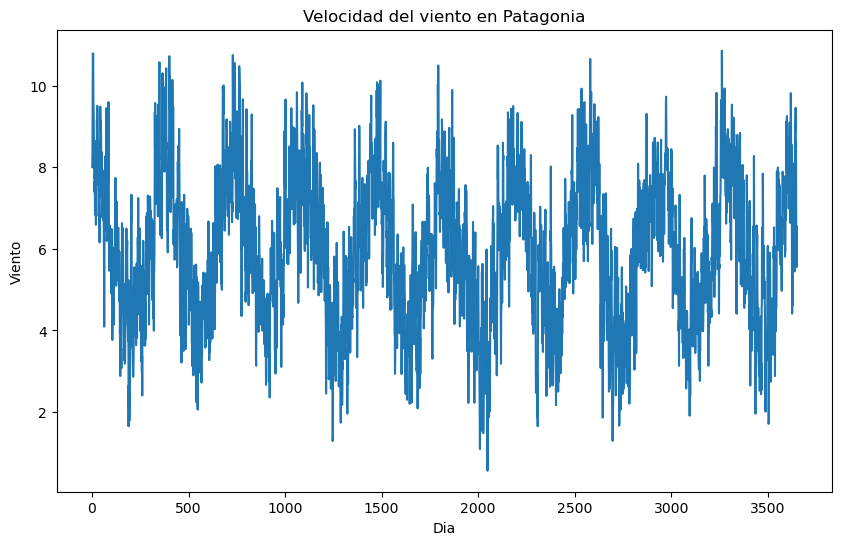

In [63]:
plt.figure(figsize=(10, 6))
plt.plot(viento['dia'], viento['regional wind'])
plt.xlabel('Dia')
plt.ylabel('Viento')
plt.title('Velocidad del viento en Patagonia')
plt.show()

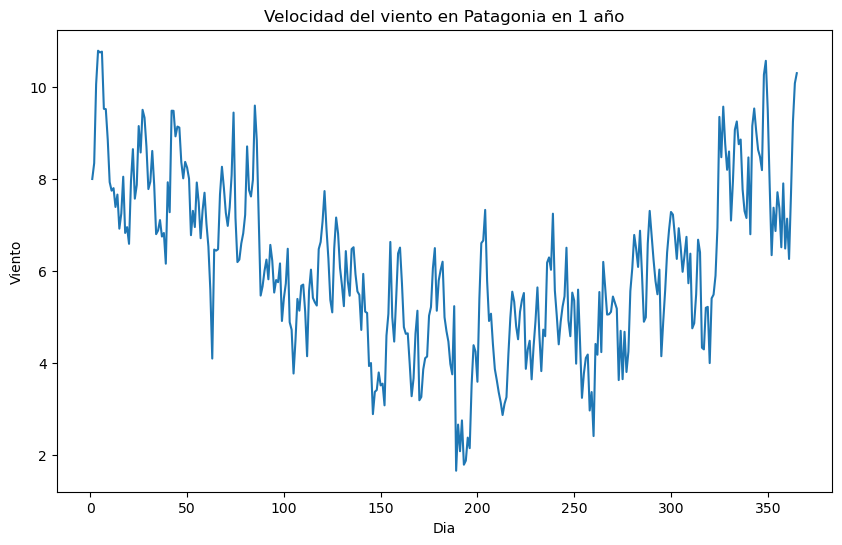

In [64]:
viento_365 = viento[(viento['dia'] >= 1) & (viento['dia'] <= 365)]
plt.figure(figsize=(10, 6))
plt.plot(viento_365['dia'], viento_365['regional wind'])
plt.xlabel('Dia')
plt.ylabel('Viento')
plt.title('Velocidad del viento en Patagonia en 1 año')
plt.show()
    

### Estimamos los valores $ \kappa, \sigma, \beta, \gamma $ usando regresión lineal

Ecuación 1  
 $ S_{i+1} - S_i = \kappa(\theta - S_i)\delta + \sigma\sqrt{\delta}Z $  
 $ S_{i+1} - S_i = Y_i $  
 $ (\theta - S_i)\delta = X_i $  
 $ \sigma\sqrt{\delta} = c $

 Regresión lineal  
 $ Y_i = \kappa X_i + cZ_i $ ----> $ Z_i ~ N(0, c^2) $ 
 

In [65]:
delta = 1/365
theta = 6 + 2 * np.cos(2 * np.pi * np.array(range(3649)) / 365)

Y = (viento["regional wind"][1:]-viento["regional wind"].shift(1)[1:]).values
X = ((theta - viento["regional wind"][:-1])*delta).values

regresion = LinearRegression().fit(X.reshape(-1,1), Y)
Y_pred = regresion.predict(X.reshape(-1,1))
error = Y-Y_pred
c = error.var()
S_0 = viento["regional wind"].iloc[0]
kappa = regresion.coef_[0]
sigma = np.sqrt(c/delta)

# Resultados
print("Estimación de kappa:", kappa)
print("Estimación de sigma:", sigma)

Estimación de kappa: 109.25679788838744
Estimación de sigma: 16.043719733423078


Ecuación 2  
 $ D_{i+1} - D_i = \beta D_i \delta + \gamma\sqrt{\delta}W_i $  
 $ D_{i+1} - D_i = Y_i $  
 $ -D_i\delta = X_i $  
 $ \gamma\sqrt{\delta} = c $

 Regresión lineal  
 $ Y_i = \beta X_i + cZ_i $ ----> $ Z_i ~ N(0, c^2) $ 

In [66]:
Y = (viento["wind gap norte sur"][1:] - viento["wind gap norte sur"].shift(1)[1:]).values
X = (-viento["wind gap norte sur"][:-1] * delta).values

regresion = LinearRegression().fit(X.reshape(-1, 1), Y)
Y_pred = regresion.predict(X.reshape(-1, 1))
error = Y - Y_pred
c = error.var()
beta = regresion.coef_[0] 
gamma = np.sqrt(c / delta)

# Resultados
print("Estimación de beta:", beta)
print("Estimación de gamma:", gamma)


Estimación de beta: 48.377333231943766
Estimación de gamma: 10.09071995713833


In [67]:
# Gráfico de residuos
# plt.figure(figsize=(10, 5))
# plt.plot(error, label='Residuos')
# plt.axhline(error.mean(), color='red', linestyle='--', label='Media')
# plt.xlabel('Días')
# plt.ylabel('Error')
# plt.title('Residuos de la regresión para estimar beta y gamma')
# plt.legend()
# plt.show()


### Simulamos el viento regional durante un año

Primero definimos las funciones para simular el viento regional y los gaps entre el viento en el molino norte y sur. <br>
Luego simulamos y visualizamos los caminos simulados.

In [68]:
def regional_wind_paths(S_0, k, theta, sigma, delta, T, m):   
    #Si+1 - Si = k(theta - si)delta + sigma*raiz(delta)*shock
    S = np.zeros((m,T+1))
    S[:,0] = S_0
    for i in range(m):
        for t in range(1,T+1):
            S[i,t] = S[i, t-1]+k*(theta[t-1]-S[i,t-1])*delta + sigma*np.sqrt(delta)*np.random.normal(0,1)
    return S

def gap_wind_paths(D_0, beta, gamma, delta, T, m):
    D = np.zeros((m, T+1))
    D[:,0] = D_0
    for i in range(m):
        for t in range(1, T+1):
            D[i, t] = D[i, t-1] - beta*D[i, t-1]*delta + gamma*np.sqrt(delta)*np.random.normal(0, 1)
    return D

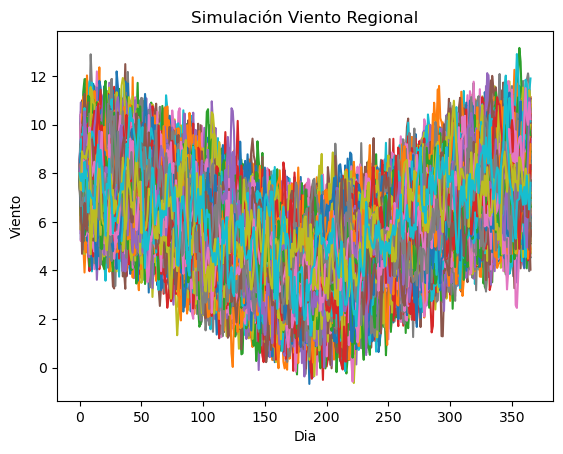

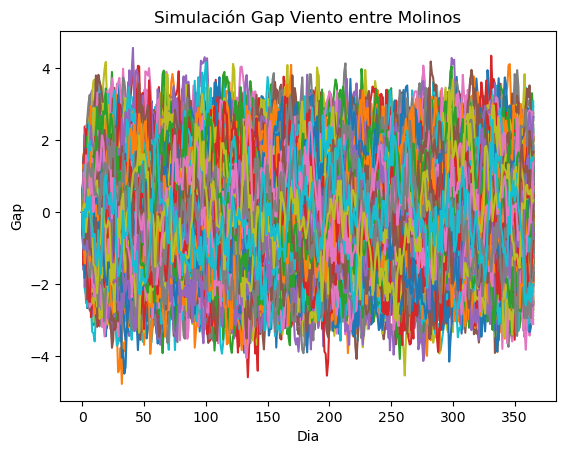

In [69]:
#simulacion 1 año viento regional
S_0 = viento["regional wind"].iloc[0]
D_0 = viento["wind gap norte sur"].iloc[0]
num_sim = 1000
T = 365
S = regional_wind_paths(S_0, kappa, theta, sigma,delta, T, num_sim)
D = gap_wind_paths(D_0, beta, gamma, delta, T, num_sim)

for s_i in S:
    plt.plot(s_i)
plt.xlabel('Dia')
plt.ylabel('Viento')
plt.title('Simulación Viento Regional')
plt.show()

for d_i in D:
    plt.plot(d_i)
plt.xlabel('Dia')
plt.ylabel('Gap')
plt.title('Simulación Gap Viento entre Molinos')
plt.show()



### Simulamos el viento durante un año en cada molino
A partir de nuestras simulaciones del viento regional y el gap entre molinos generamos el viento en cada molino

In [70]:
viento_molino_norte = S + 0.5*D
viento_molino_norte= np.maximum(viento_molino_norte, 0) # No tiene sentido que el viento sea negativo

    
viento_molino_sur = S - 0.5*D
viento_molino_sur = np.maximum(viento_molino_sur, 0) # No tiene sentido que el viento sea negativo


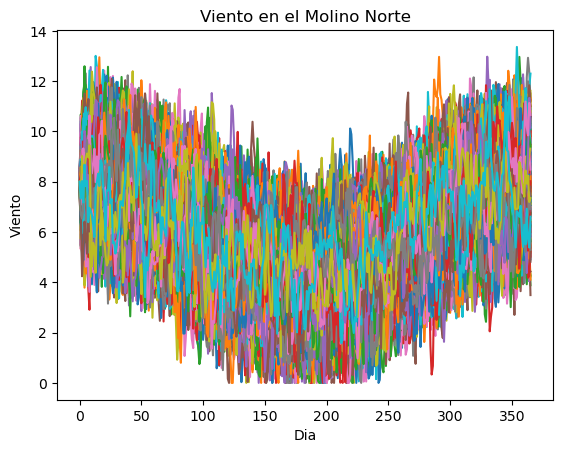

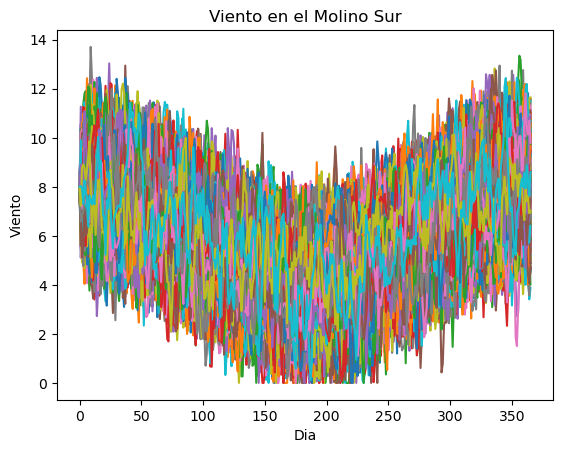

In [71]:
for vn_i in viento_molino_norte:
    plt.plot(vn_i)
plt.xlabel('Dia')
plt.ylabel('Viento')
plt.title('Viento en el Molino Norte')
plt.show()
for vs_i in viento_molino_sur:
    plt.plot(vs_i)
plt.xlabel('Dia')
plt.ylabel('Viento')
plt.title('Viento en el Molino Sur')
plt.show()

#### Comparación
Vamos a comparar nuestra simulación del viento regional con los datos. <br>

Para esto como tenemos datos de 3650 días = 10 años, graficamos los datos de cada año en un mismo gráfico. Y lo comparamos con 10 simulaciones de un año de viento regional. Vemos que los gráficos son parecidos, tienen la misma forma.

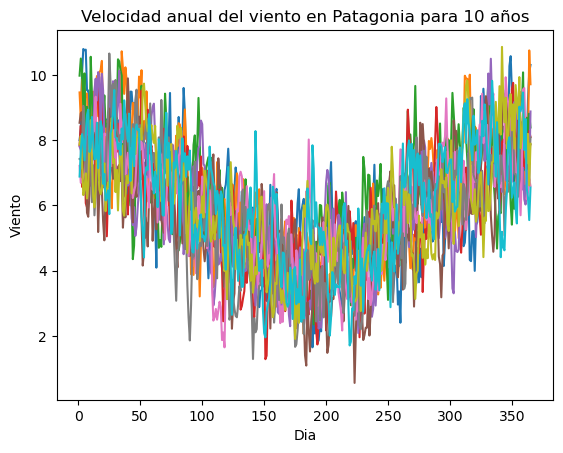

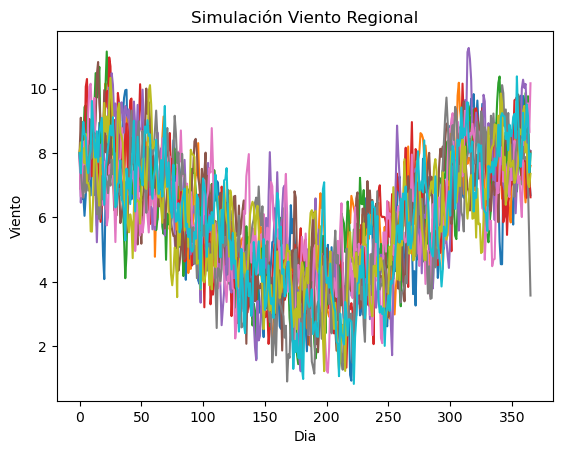

In [72]:
# Gráfico 10 años de datos sobre viento regional
d = 1
for i in range(0,10):
    viento_365 = viento[(viento['dia'] >= d+365*i) & (viento['dia'] <= 365+365*i)]
    plt.plot(viento_365['dia']-365*i, viento_365['regional wind'])
plt.xlabel('Dia')
plt.ylabel('Viento')
plt.title('Velocidad anual del viento en Patagonia para 10 años')
plt.show()


# Simulación 10 años de viento regional
num_sim = 10
S_comp = regional_wind_paths(S_0, kappa, theta, sigma,delta, T, num_sim)

for s_i in S_comp:
    plt.plot(s_i)
plt.xlabel('Dia')
plt.ylabel('Viento')
plt.title('Simulación Viento Regional')
plt.show()

Podemos hacer lo mismo con los gaps

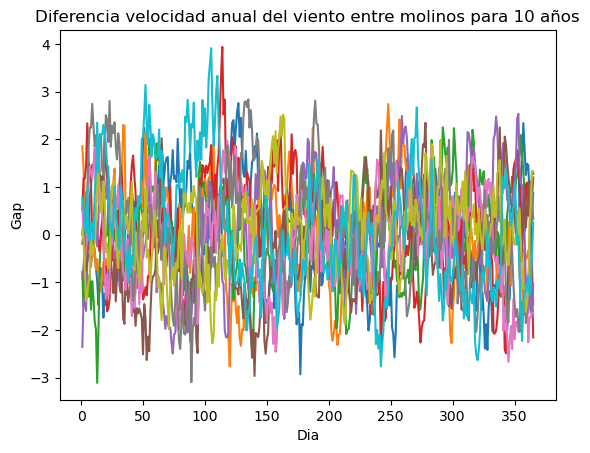

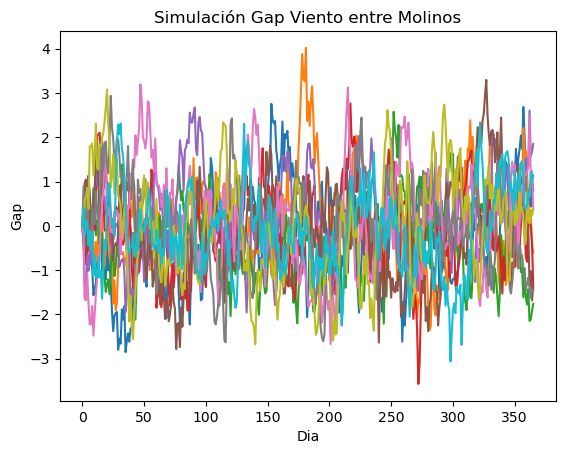

In [73]:
# Gráfico 10 años de datos sobre gap entre viento en molino norte y molino sur
d = 1
for i in range(0,10):
    viento_365 = viento[(viento['dia'] >= d+365*i) & (viento['dia'] <= 365+365*i)]
    plt.plot(viento_365['dia']-365*i, viento_365['wind gap norte sur'])
plt.xlabel('Dia')
plt.ylabel('Gap')
plt.title('Diferencia velocidad anual del viento entre molinos para 10 años')
plt.show()


# Simulación 10 años de gap entre viento en molino norte y molino sur
num_sim = 10
D_comp = gap_wind_paths(D_0, beta, gamma, delta, T, num_sim)

for d_i in D_comp:
    plt.plot(d_i)
plt.xlabel('Dia')
plt.ylabel('Gap')
plt.title('Simulación Gap Viento entre Molinos')
plt.show()

Gráficamos el viento en cada molino usando los datos. Al igual que antes gráficamos 10 años del viento.

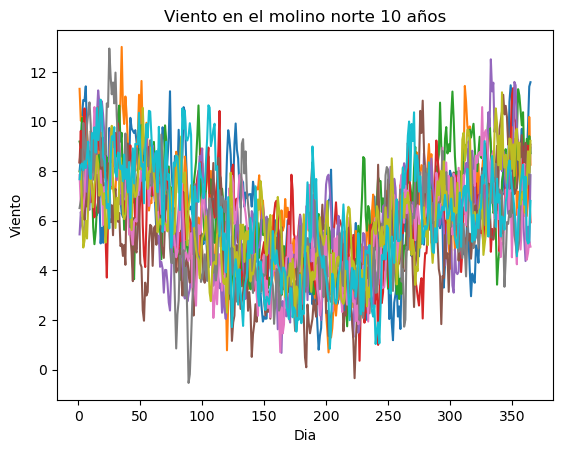

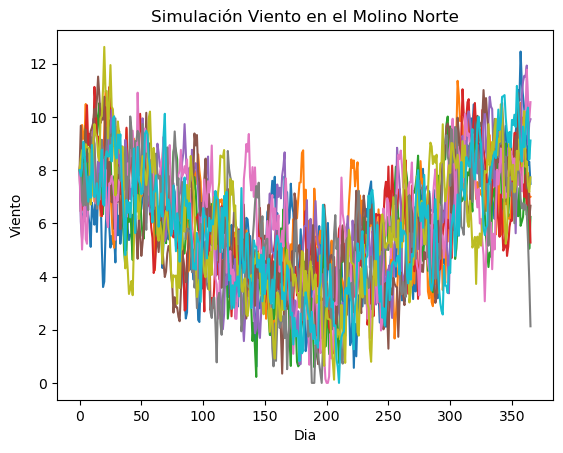

In [74]:
# Gráfico 10 años de datos sobre el viento en el molino norte
d = 1
for i in range(0,10):
    viento_365 = viento[(viento['dia'] >= d+365*i) & (viento['dia'] <= 365+365*i)]
    plt.plot(viento_365['dia']-365*i, viento_365['regional wind'] + viento_365['wind gap norte sur'])
plt.xlabel('Dia')
plt.ylabel('Viento')
plt.title('Viento en el molino norte 10 años')
plt.show()


# Simulación viento en el molino norte
viento_molino_norte_comp = S_comp + D_comp
viento_molino_norte_comp = np.maximum(viento_molino_norte_comp, 0) # No tiene sentido que el viento sea negativo


for vn_i in viento_molino_norte_comp:
    plt.plot(vn_i)
plt.xlabel('Dia')
plt.ylabel('Viento')
plt.title('Simulación Viento en el Molino Norte')
plt.show()


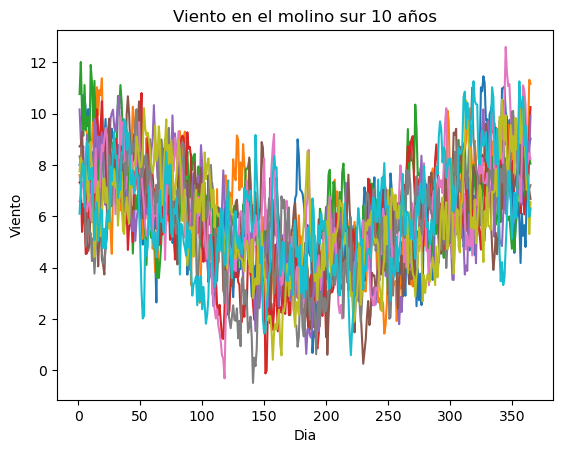

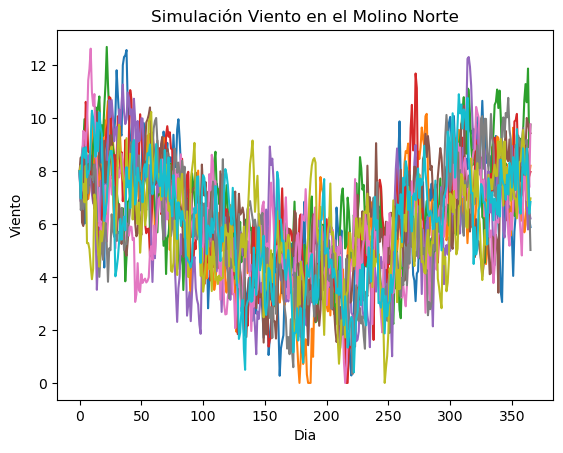

In [75]:
# Gráfico 10 años de datos sobre el viento en el molino sur
d = 1
for i in range(0,10):
    viento_365 = viento[(viento['dia'] >= d+365*i) & (viento['dia'] <= 365+365*i)]
    plt.plot(viento_365['dia']-365*i, viento_365['regional wind'] - viento_365['wind gap norte sur'])
plt.xlabel('Dia')
plt.ylabel('Viento')
plt.title('Viento en el molino sur 10 años')
plt.show()


# Simulación viento en el molino sur
viento_molino_sur_comp = S_comp - D_comp
viento_molino_sur_comp = np.maximum(viento_molino_sur_comp, 0) # No tiene sentido que el viento sea negativo


for vn_i in viento_molino_sur_comp:
    plt.plot(vn_i)
plt.xlabel('Dia')
plt.ylabel('Viento')
plt.title('Simulación Viento en el Molino Norte')
plt.show()

### Simulación Completa
Agregando evolución simultánea del tiempo en cada molino, las roturas, las decisiones de apagado y encendido, y la acumulación de cashflows en el tiempo

In [76]:
def simulate_molino(S, K, delta, repair_cost=200000, shut_cost=1000, income_rate=1000, interest_rate=0.05):
    T = S.shape[1] - 1  
    N = S.shape[0]  
    
    cashflows = np.zeros((N, T))
    molino_activo = np.ones((N, T), dtype=bool)  # Molino comienza activo
    molino_apagado = np.zeros((N, T), dtype=bool)
    molino_roto = np.zeros((N,T), dtype=bool)
    
    for i in range(N):
        for t in range(T):
            if t==0: #Molino arranca activo
                cashflows[i, t] += income_rate * S[i, t]
            
            #Si el molino estuvo activo el día anterior
            elif molino_activo[i, t-1]:
                prob_rotura = 0.25 * (S[i, t] ** 2) * delta  
                if np.random.rand() < prob_rotura: #si se rompe el molino   
                    cashflows[i, t] -= repair_cost 
                    molino_activo[i, t] = False
                    molino_roto[i, t] = True  
                else: #si el molino no se rompe
                    # Si se pasa el umbral K, se apaga el molino
                    if S[i, t] > K:
                        cashflows[i, t] -= shut_cost  # costo de apagado
                        molino_activo[i, t] = False
                        molino_apagado[i, t] = True
                    else:
                        molino_activo[i, t] = True
                        cashflows[i, t] += income_rate * S[i, t] #ingreso en el dia i

            #Si el molino estuvo apagado el día anterior
            else: 
                if S[i, t] < K: # se vuelve a prender si S[i, t] < K
                    molino_activo[i, t] = True  
                    cashflows[i, t] += income_rate * S[i, t] #ingreso en el dia i
                else: # Permanece apagado si S[i, t] > K
                    molino_activo[i, t] = False
                    molino_apagado[i, t] = True  
            
            #Descuento de cashflows por tasas de interes
            cashflows[i, t] *= np.exp(-interest_rate * t / 365)
    
    #Valor Actual Neto esperado
    van_simulaciones = np.sum(cashflows, axis=1)
    van = np.mean(van_simulaciones)
    error_van = np.std(van_simulaciones)/np.sqrt(N)

    return van, cashflows, molino_activo, molino_apagado, molino_roto, error_van


In [77]:
K = 7  # Umbral de apagado arbitrario

#Simulacion molino norte
van_norte, cashflows_norte, activo_norte, apagado_norte, roto_norte, se_norte= simulate_molino(viento_molino_norte, K, delta)

#Simulacion molino sur
van_sur, cashflows_sur, activo_sur, apagado_sur, roto_sur, se_sur= simulate_molino(viento_molino_sur, K, delta)


In [78]:
print(f"VAN esperado molino Norte: ${van_norte:.2f}")
print(f"VAN esperado molino Sur: ${van_sur:.2f}")
print(f"Error estandar van norte: {se_norte:.2f}")
print(f"Error estandar van sur: {se_sur:.2f}")

VAN esperado molino Norte: $272151.54
VAN esperado molino Sur: $242195.04
Error estandar van norte: 13003.16
Error estandar van sur: 12895.64


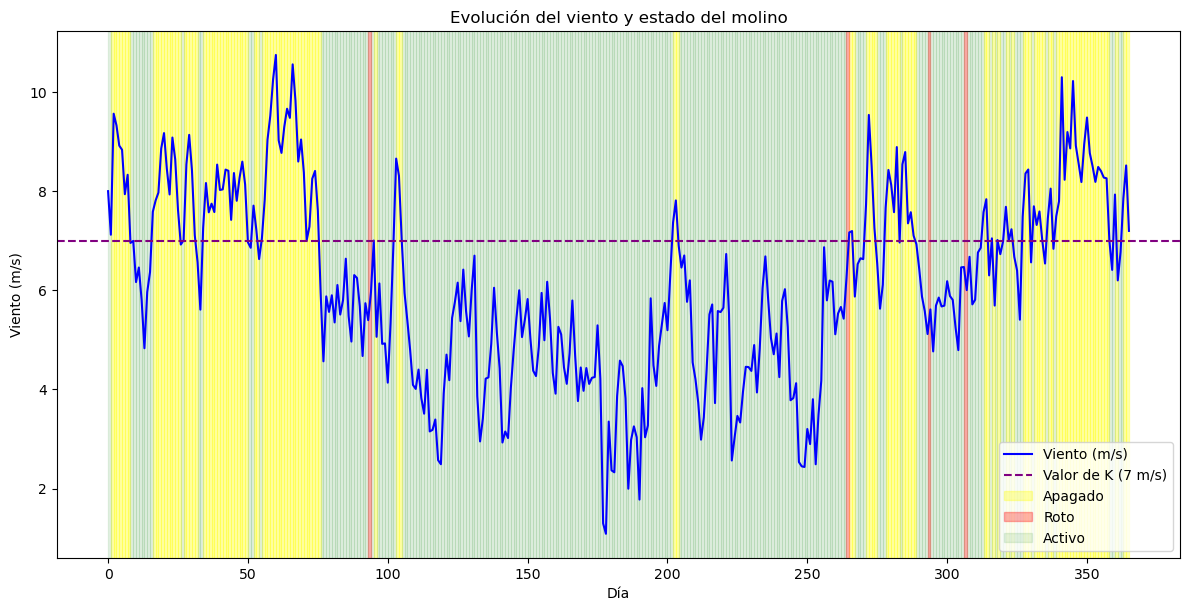

In [79]:
camino_viento = viento_molino_sur[0]

_, cashflows, active, shut_downs, breakdowns,_ = simulate_molino(
    S=camino_viento.reshape(1, -1),
    K=7,
    delta=delta
)

estado_molino = np.ones_like(active[0], dtype=int)
estado_molino[shut_downs[0]] = 0
estado_molino[breakdowns[0]] = -1

fig, ax1 = plt.subplots(figsize=(12, 6))

# Grafico del viento
ax1.plot(camino_viento, label="Viento (m/s)", color="blue")
ax1.set_xlabel("Día")
ax1.set_ylabel("Viento (m/s)", color="black")
ax1.tick_params(axis='y', labelcolor="black")
ax1.axhline(y=7, color="purple", linestyle="--", label=f"Valor de K ({K} m/s)")

legend_elements = {
    'Apagado': {'color': 'yellow', 'alpha': 0.3},
    'Roto': {'color': 'red', 'alpha': 0.3},
    'Activo': {'color': 'green', 'alpha': 0.1}
}

for state, properties in legend_elements.items():
    indices = np.where(estado_molino == {'Apagado': 0, 'Roto': -1, 'Activo': 1}[state])[0]
    for i in indices:
        ax1.axvspan(i, i+1, color=properties['color'], alpha=properties['alpha'], label=state if i == indices[0] else "")

ax1.legend(loc="lower right")

fig.tight_layout()
plt.title("Evolución del viento y estado del molino")
plt.show()


### VAN

In [80]:
umbrales = [0,1,2,3,4,5,6,7,8,9,10,11,12,1000]
vanes_norte = []
errores_norte = []
for u in umbrales:
    vn_u, _,_,_,_, std_error_norte_u= simulate_molino(viento_molino_norte, u, delta)
    vanes_norte.append(vn_u)
    errores_norte.append(std_error_norte_u)
mejor_umbral_norte = umbrales[vanes_norte.index(max(vanes_norte))]
mejor_van_norte = vanes_norte[vanes_norte.index(max(vanes_norte))]
se_mejor_umbral_norte = errores_norte[vanes_norte.index(max(vanes_norte))]

In [81]:
umbrales = [0,1,2,3,4,5,6,7,8,9,10,11,12,1000]
vanes_sur = []
errores_sur = []
for u in umbrales:
    vs_u, _,_,_,_, std_error_sur_u = simulate_molino(viento_molino_sur, u, delta)
    vanes_sur.append(vs_u)
    errores_sur.append(std_error_sur_u)
mejor_umbral_sur = umbrales[vanes_sur.index(max(vanes_sur))]
mejor_van_sur = vanes_sur[vanes_sur.index(max(vanes_sur))]
se_mejor_umbral_sur = errores_sur[vanes_sur.index(max(vanes_sur))]

In [82]:
print(f"Umbral óptimo para maximización de VAN en molino norte: {mejor_umbral_norte}. VAN esperado de {mejor_van_norte:.2f} con error estándar de {se_mejor_umbral_norte:.2f}")
print(f"Umbral óptimo para maximización de VAN en molino sur: {mejor_umbral_sur}. VAN esperado: {mejor_van_sur:.2f} con error estándar de {se_mejor_umbral_sur:.2f}")


Umbral óptimo para maximización de VAN en molino norte: 7. VAN esperado de 267533.39 con error estándar de 12674.49
Umbral óptimo para maximización de VAN en molino sur: 8. VAN esperado: 262247.99 con error estándar de 15932.35


In [83]:
print(f"Si se mantiene siempre prendido el molino norte, el VAN esperado en cambio es de {vanes_norte[-1]:.2f}")
print(f"Si se mantiene siempre prendido el molino sur, el VAN esperado en cambio es de {vanes_sur[-1]:.2f}")

Si se mantiene siempre prendido el molino norte, el VAN esperado en cambio es de 186430.95
Si se mantiene siempre prendido el molino sur, el VAN esperado en cambio es de 187840.55


### Gráficos simulacion molino norte

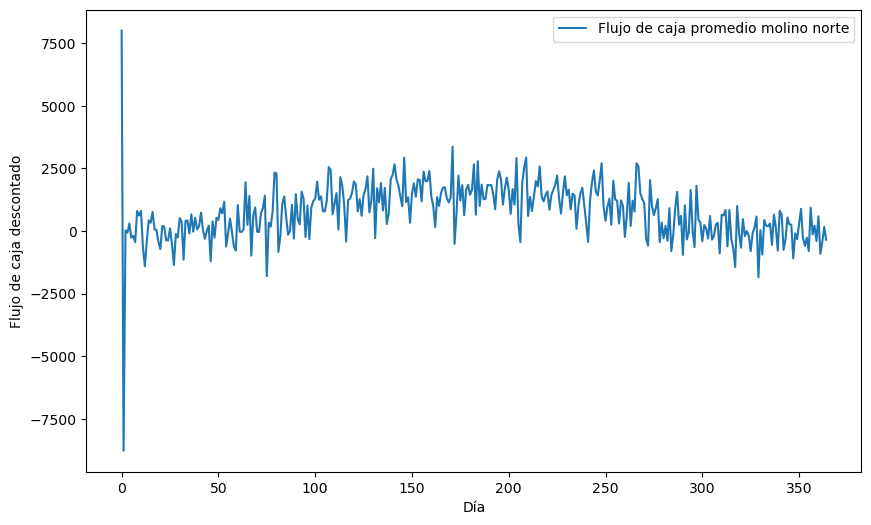

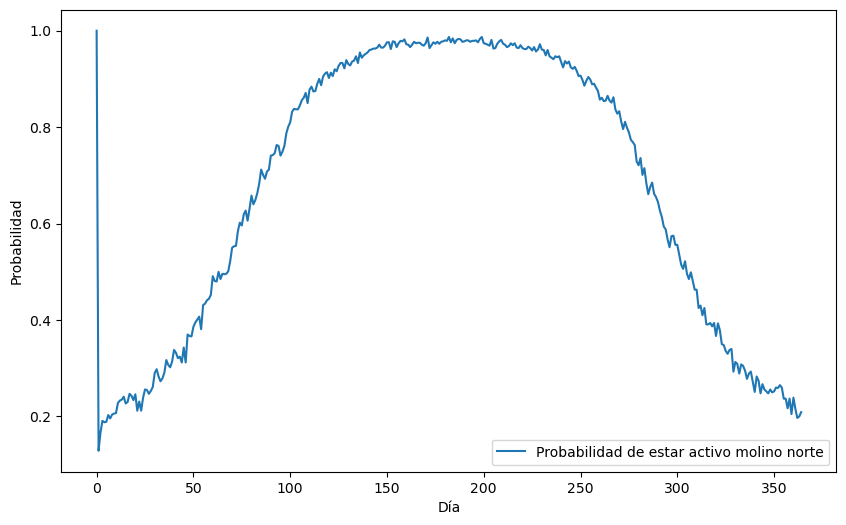

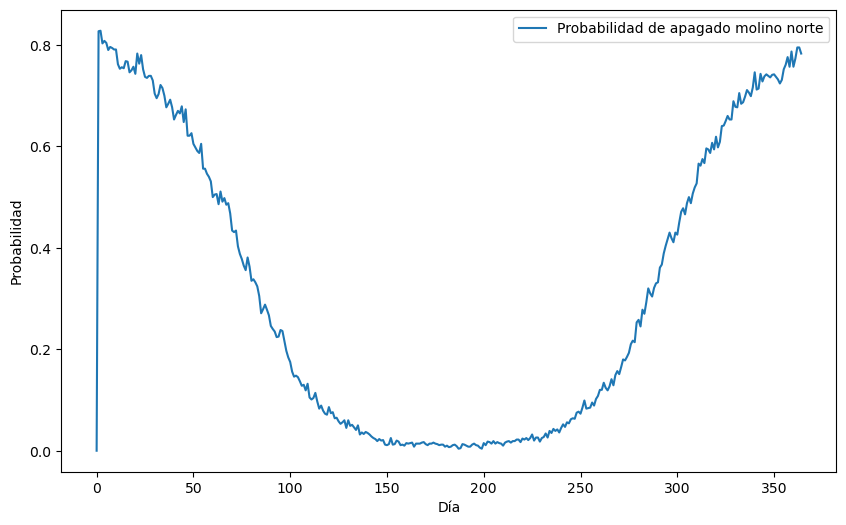

In [84]:
#Gráficos molino norte
plt.figure(figsize=(10, 6))
plt.plot(np.mean(cashflows_norte, axis=0), label="Flujo de caja promedio molino norte")
plt.xlabel("Día")
plt.ylabel("Flujo de caja descontado")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(np.mean(activo_norte, axis=0), label="Probabilidad de estar activo molino norte")
plt.xlabel("Día")
plt.ylabel("Probabilidad")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(np.mean(apagado_norte, axis=0), label="Probabilidad de apagado molino norte")
plt.xlabel("Día")
plt.ylabel("Probabilidad")
plt.legend()
plt.show()

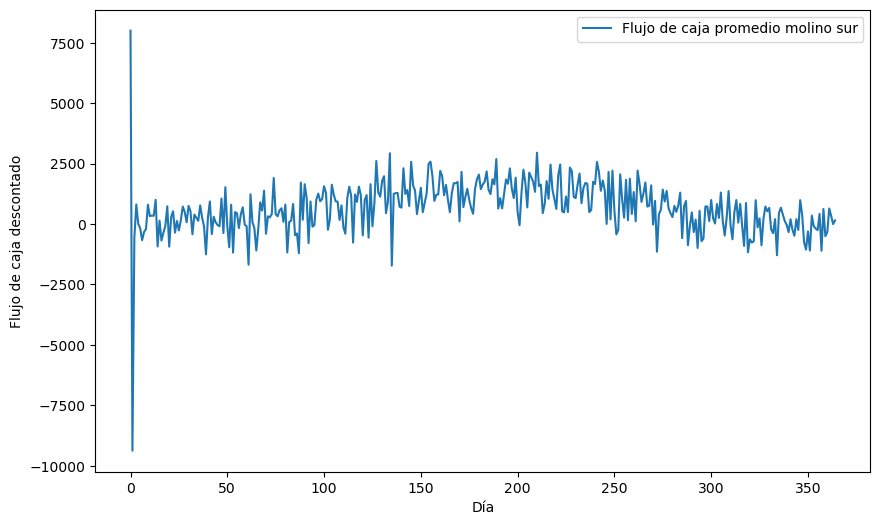

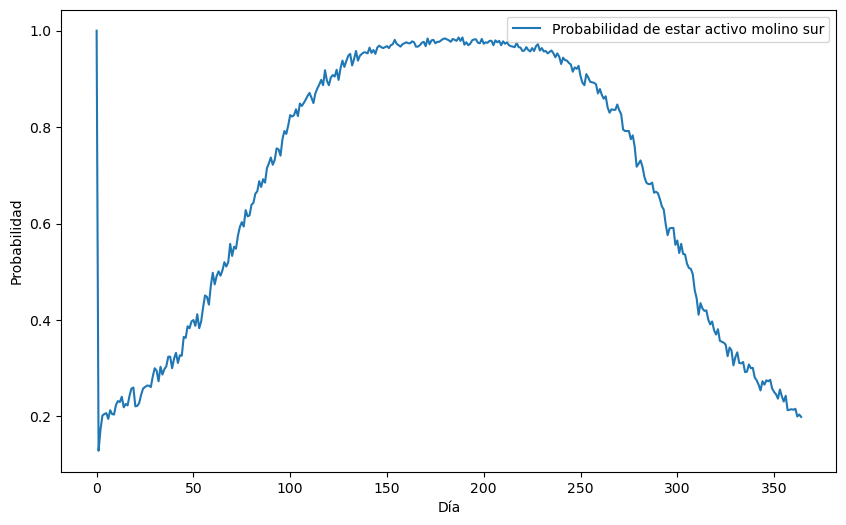

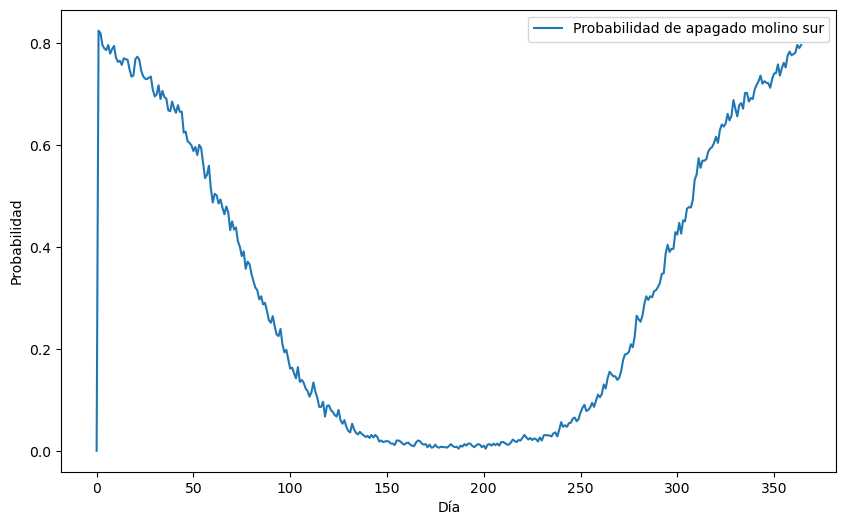

In [85]:
#Gráficos molino sur
plt.figure(figsize=(10, 6))
plt.plot(np.mean(cashflows_sur, axis=0), label="Flujo de caja promedio molino sur")
plt.xlabel("Día")
plt.ylabel("Flujo de caja descontado")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(np.mean(activo_sur, axis=0), label="Probabilidad de estar activo molino sur")
plt.xlabel("Día")
plt.ylabel("Probabilidad")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(np.mean(apagado_sur, axis=0), label="Probabilidad de apagado molino sur")
plt.xlabel("Día")
plt.ylabel("Probabilidad")
plt.legend()
plt.show()

### Analisis

In [86]:
# Estrategia óptima con umbral 7
_, _, _, _, roturas_optima, _ = simulate_molino(viento_molino_sur, 7, delta)
roturas_medio_optima = np.mean(np.sum(roturas_optima, axis=1))

# Estrategia que nunca apaga (umbral 100)
_, _, _, _, roturas_nunca_apaga, _ = simulate_molino(viento_molino_sur, 100, delta)
roturas_medio_nunca_apaga = np.mean(np.sum(roturas_nunca_apaga, axis=1))

print("Número medio de roturas por año (estrategia óptima):", roturas_medio_optima)
print("Número medio de roturas por año (nunca se apaga):", roturas_medio_nunca_apaga)

Número medio de roturas por año (estrategia óptima): 4.879
Número medio de roturas por año (nunca se apaga): 9.601


In [60]:
# Estrategia óptima con umbral 7
_, _, _, apagado, roturas, _ = simulate_molino(viento_molino_sur, 7, delta)
molino_inactivo = np.mean(np.sum(roturas, axis=1) + np.sum(apagado, axis=1))

print("Número medio de días inactivo del molino por año:", molino_inactivo)

Número medio de días inactivo del molino por año: 118.431
